## Imports
---

In [ ]:
# Imports
from scipy.stats import poisson
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
from matplotlib.pyplot import cm
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## Reading in and Formatting the Muon Dataset
___

In [2]:
# Reading in data and checking it
data = pd.read_csv("muon_data.csv", comment='#', names = ['Index', 'ep', 'eta', 'p', 'phi', 'pol', 'pt', 'qp', 'tx', 'ty', 'zV'], skiprows=1)
data.loc[:, data.columns!='Index']

,ep,eta,p,phi,pol,pt,qp,tx,ty,zV
0,0.005459,3.210803,72.079880,0.294754,1.0,5.803692,72.079880,0.077296,0.023467,-60.3975
1,0.004050,4.436362,37.638340,-0.088796,1.0,0.891071,-37.638340,0.023588,-0.002100,-60.3975
2,0.003901,3.577396,18.565832,0.319936,1.0,1.036960,18.565832,0.053102,0.017594,-60.3975
3,0.003859,3.532860,8.632520,0.219504,1.0,0.504075,-8.632520,0.057089,0.012736,-60.3975
4,0.004975,3.300828,43.359665,-0.720869,1.0,3.191501,43.359665,0.055445,-0.048714,-8.0373
...,...,...,...,...,...,...,...,...,...,...
208979,0.007196,4.140301,7.805385,0.284841,-1.0,0.248430,-7.805385,0.030561,0.008948,-10.3122
208980,0.007210,3.852298,160.216980,2.341455,-1.0,6.800037,160.216980,-0.029593,0.030478,-47.0282
208981,0.004592,4.234431,32.691210,1.112678,-1.0,0.947065,-32.691210,0.012818,0.025994,-47.0282
208982,0.003816,4.122482,14.349394,2.564155,-1.0,0.464920,14.349394,-0.027161,0.017696,-47.0282


## Scatter Plot of Momentum Resolution
---

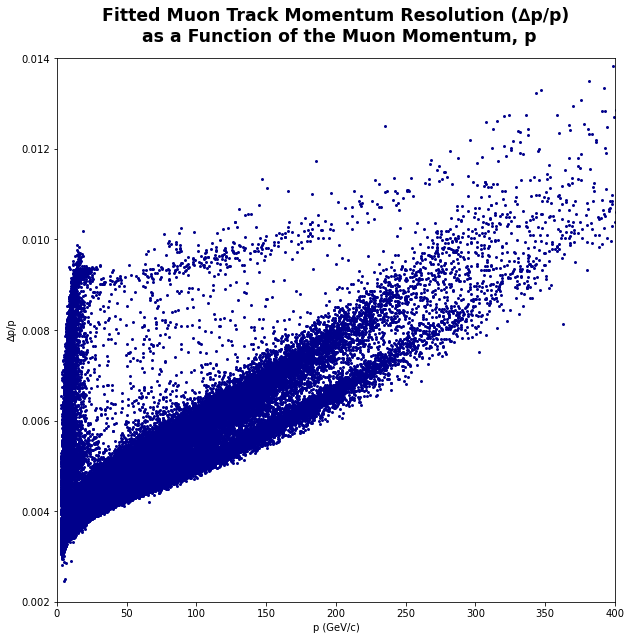

In [3]:
# Producing momentum band scatter plot
plt.scatter(data['p'], data['ep'], marker='.', linewidth=0.001, color='darkblue')
plt.xlim(0, 400)
plt.ylim(0.002, 0.014)
plt.title('Fitted Muon Track Momentum Resolution (∆p/p)\n as a Function of the Muon Momentum, p', y=1.02, weight='bold', size='xx-large')
plt.xlabel('p (GeV/c)')
plt.ylabel('∆p/p')
plt.show()

## Momentum Distribution
___

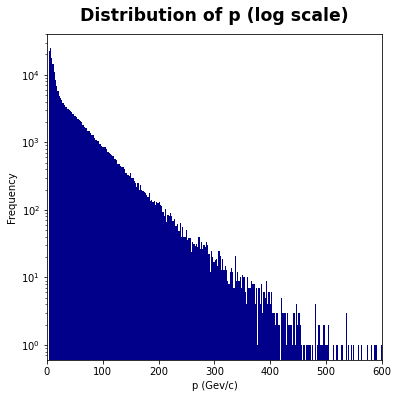

In [4]:
# Plotting the distribution of p with a log scale
plt.rcParams["figure.figsize"] = (6,6)
plt.hist(data['p'], bins=500, color='darkblue')
plt.title('Distribution of p (log scale)', y=1.02, weight='bold', size='xx-large')
plt.xlim(0, 600)
plt.xlabel('p (Gev/c)')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

## Track Momentum Distribution
___

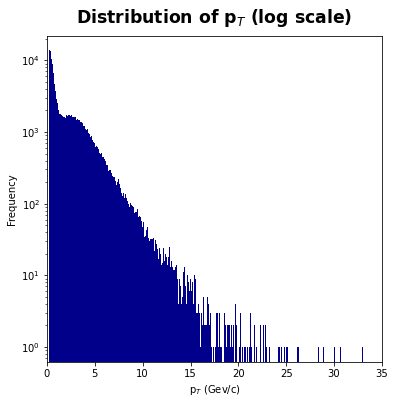

In [5]:
# Plotting the distribution of p with a log scale
plt.hist(data['pt'], bins=500, color='darkblue')
plt.title('Distribution of p$_T$ (log scale)', y=1.02, weight='bold', size='xx-large')
plt.xlim(0, 35)
plt.xlabel('p$_T$ (Gev/c)')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

## Adding Variables $p_{z}$ and $\frac{\Delta_{p_{z}}}{p_{z}}$ to the Dataframe
---

From the momentum relation:

$$ p^{2} = p_{z}^{2} + p_{t}^{2}$$
$$ p_{z} ​= \sqrt{p^{2} − p_{t}^{2}}$$ 

Where: $p$ = total momentum, $p_{t}$ ​= momentum perpendicular to the z-axis, $p_{z}$ = momentum along the z-axis

​

In [6]:
new_data_1 = pd.concat([data, pd.Series(np.sqrt(data['p']**2 - data['pt']**2), name='pz')], axis=1)
new_data = pd.concat([new_data_1, pd.Series(new_data_1['ep']*new_data_1['p']/new_data_1['pz'], name='epz')], axis=1)

In [7]:
new_data

,Index,ep,eta,p,phi,pol,pt,qp,tx,ty,zV,pz,epz
0,0,0.005459,3.210803,72.079880,0.294754,1.0,5.803692,72.079880,0.077296,0.023467,-60.3975,71.845851,0.005477
1,1,0.004050,4.436362,37.638340,-0.088796,1.0,0.891071,-37.638340,0.023588,-0.002100,-60.3975,37.627791,0.004052
2,2,0.003901,3.577396,18.565832,0.319936,1.0,1.036960,18.565832,0.053102,0.017594,-60.3975,18.536851,0.003908
3,3,0.003859,3.532860,8.632520,0.219504,1.0,0.504075,-8.632520,0.057089,0.012736,-60.3975,8.617790,0.003866
4,4,0.004975,3.300828,43.359665,-0.720869,1.0,3.191501,43.359665,0.055445,-0.048714,-8.0373,43.242050,0.004989
...,...,...,...,...,...,...,...,...,...,...,...,...,...
208979,208979,0.007196,4.140301,7.805385,0.284841,-1.0,0.248430,-7.805385,0.030561,0.008948,-10.3122,7.801430,0.007200
208980,208980,0.007210,3.852298,160.216980,2.341455,-1.0,6.800037,160.216980,-0.029593,0.030478,-47.0282,160.072609,0.007216
208981,208981,0.004592,4.234431,32.691210,1.112678,-1.0,0.947065,-32.691210,0.012818,0.025994,-47.0282,32.677489,0.004594
208982,208982,0.003816,4.122482,14.349394,2.564155,-1.0,0.464920,14.349394,-0.027161,0.017696,-47.0282,14.341860,0.003818


## Creating the $\frac{\Delta_{p_{z}}}{p_{z}}$ vs. $p_{z}$ Scatter Plot
---

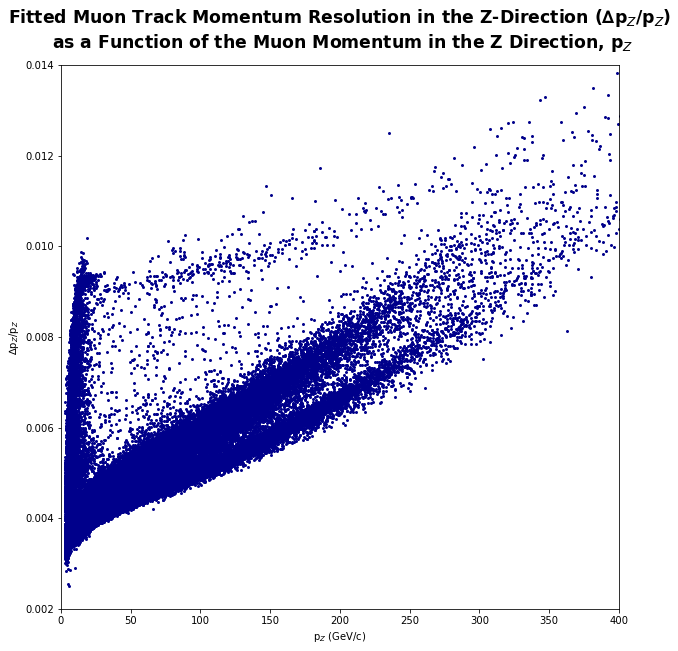

In [8]:
# Producing the momentum band scatter plot from the notes for the z direction
plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(new_data['pz'], new_data['epz'], marker='.', linewidth=0.001, color='darkblue')
plt.xlim(0, 400)
plt.ylim(0.002, 0.014)
plt.title('Fitted Muon Track Momentum Resolution in the Z-Direction (∆p$_Z$/p$_Z$)\n as a Function of the Muon Momentum in the Z Direction, p$_Z$', y=1.02, weight='bold', size='xx-large')
plt.xlabel('p$_Z$ (GeV/c)')
plt.ylabel('∆p$_Z$/p$_Z$')
plt.show()

# Building a Regression Model to Predict Muon Track Momentum Resolution
---

In [9]:
# No. of inputs = 5 (p, tx, ty, eta, phi), no. of outputs = 1 (ep)
num_inputs = 5
num_outputs = 1

# Simple Keras model which uses the same no. of nodes as no. of inputs with a single layer
num_nodes = num_inputs

def simple_model():
    # Create model
    model = Sequential()
    
    # No activation required for the output as this is a regression problem
    model.add(Dense(num_nodes, input_dim=num_inputs,  kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_outputs, kernel_initializer='normal'))
    
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [10]:
# Define model fitting parameters
n_epochs = 50
batch_size = 100
seed_no = 42
np.random.seed(seed_no)

# Defining the data and targets
model_data = data[['p', 'tx', 'ty', 'eta', 'phi']]
model_target = data['ep']

estimator = KerasRegressor(build_fn=simple_model, epochs=n_epochs, batch_size = batch_size)
kfold = KFold(n_splits=10, random_state=seed_no, shuffle = True)

# Data and target are 5 - column and 1 - column arrays produced with pandas.DataFrame.values
results = cross_val_score(estimator, model_data, model_target, cv=kfold, scoring='r2')

2022-03-10 20:43:36.616842: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-10 20:43:36.664794: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/50
1881/1881 [==============================] - 1s 335us/step - loss: 0.0138
Epoch 2/50
1881/1881 [==============================] - 1s 365us/step - loss: 5.5565e-07
Epoch 3/50
1881/1881 [==============================] - 1s 336us/step - loss: 5.2569e-07
Epoch 4/50
1881/1881 [==============================] - 1s 335us/step - loss: 5.2529e-07
Epoch 5/50
1881/1881 [==============================] - 1s 330us/step - loss: 5.4170e-07
Epoch 6/50
1881/1881 [==============================] - 1s 364us/step - loss: 6.1211e-07
Epoch 7/50
1881/1881 [==============================] - 1s 419us/step - loss: 1.0040e-06
Epoch 8/50
1881/1881 [==============================] - 1s 345us/step - loss: 5.1564e-07
Epoch 9/50
1881/1881 [==============================] - 1s 516us/step - loss: 5.3555e-07
Epoch 10/50
1881/1881 [==============================] - 1s 562us/step - loss: 4.8433e-07
Epoch 11/50
1881/1881 [==============================] - 1s 754us/step - loss: 4.8318e-07
Epoch 12/50
1881/1881 [

1881/1881 [==============================] - 1s 343us/step - loss: 5.5341e-07
Epoch 34/50
1881/1881 [==============================] - 1s 338us/step - loss: 5.6301e-07
Epoch 35/50
1881/1881 [==============================] - 1s 330us/step - loss: 5.6545e-07
Epoch 36/50
1881/1881 [==============================] - 1s 335us/step - loss: 5.7116e-07
Epoch 37/50
1881/1881 [==============================] - 1s 336us/step - loss: 5.8761e-07
Epoch 38/50
1881/1881 [==============================] - 1s 325us/step - loss: 5.7036e-07
Epoch 39/50
1881/1881 [==============================] - 1s 327us/step - loss: 5.6312e-07
Epoch 40/50
1881/1881 [==============================] - 1s 325us/step - loss: 5.6987e-07
Epoch 41/50
1881/1881 [==============================] - 1s 325us/step - loss: 5.8391e-07
Epoch 42/50
1881/1881 [==============================] - 1s 327us/step - loss: 5.7533e-07
Epoch 43/50
1881/1881 [==============================] - 1s 336us/step - loss: 5.7332e-07 0s - loss: 5.
Epoch 44

Epoch 14/50
1881/1881 [==============================] - 1s 370us/step - loss: 4.8416e-07
Epoch 15/50
1881/1881 [==============================] - 1s 332us/step - loss: 5.0712e-07
Epoch 16/50
1881/1881 [==============================] - 1s 319us/step - loss: 4.8148e-07
Epoch 17/50
1881/1881 [==============================] - 1s 388us/step - loss: 4.8488e-07
Epoch 18/50
1881/1881 [==============================] - 1s 393us/step - loss: 4.8926e-07
Epoch 19/50
1881/1881 [==============================] - 1s 388us/step - loss: 4.8691e-07
Epoch 20/50
1881/1881 [==============================] - 1s 435us/step - loss: 4.8425e-07
Epoch 21/50
1881/1881 [==============================] - 1s 360us/step - loss: 4.7773e-07
Epoch 22/50
1881/1881 [==============================] - 1s 349us/step - loss: 4.8592e-07
Epoch 23/50
1881/1881 [==============================] - 1s 381us/step - loss: 4.7184e-07
Epoch 24/50
1881/1881 [==============================] - 1s 357us/step - loss: 4.8129e-07
Epoch 25/5

In [11]:
print("Mean:", (results.mean()))
print("Standard Deviation:", results.std ())
print(results)

Mean: 0.33089593808128265
Standard Deviation: 0.20842151932351988
[ 0.33782648  0.5767842   0.52571551  0.61136756 -0.00495667  0.35304238
  0.33107322  0.38692086  0.21828349 -0.02709765]


# Evaluating Model Performance with New Estimator
---

In [12]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=simple_model, epochs = n_epochs , batch_size = batch_size)))
pipeline = Pipeline(estimators)

kfold = KFold(n_splits=10, random_state=seed_no, shuffle = True)

# Data and target are 5 - column and 1 - column arrays produced with pandas.DataFrame.values
results_new_estimator = cross_val_score(pipeline, model_data, model_target, cv=kfold, scoring='r2')

Epoch 1/50
1881/1881 [==============================] - 1s 316us/step - loss: 3.3959e-06
Epoch 2/50
1881/1881 [==============================] - 1s 313us/step - loss: 4.1774e-07 0s - loss: 4.22
Epoch 3/50
1881/1881 [==============================] - 1s 313us/step - loss: 4.0541e-07
Epoch 4/50
1881/1881 [==============================] - 1s 311us/step - loss: 4.0062e-07
Epoch 5/50
1881/1881 [==============================] - 1s 324us/step - loss: 3.9373e-07
Epoch 6/50
1881/1881 [==============================] - 1s 312us/step - loss: 3.9965e-07
Epoch 7/50
1881/1881 [==============================] - 1s 358us/step - loss: 3.8533e-07
Epoch 8/50
1881/1881 [==============================] - 1s 316us/step - loss: 3.9574e-07
Epoch 9/50
1881/1881 [==============================] - 1s 311us/step - loss: 3.9544e-07 0s - loss: 3.9713
Epoch 10/50
1881/1881 [==============================] - 1s 310us/step - loss: 3.9665e-07
Epoch 11/50
1881/1881 [==============================] - 1s 314us/step - lo

1881/1881 [==============================] - 1s 335us/step - loss: 3.8552e-07
Epoch 32/50
1881/1881 [==============================] - 1s 332us/step - loss: 4.0067e-07
Epoch 33/50
1881/1881 [==============================] - 1s 333us/step - loss: 3.9581e-07
Epoch 34/50
1881/1881 [==============================] - 1s 342us/step - loss: 3.8873e-07
Epoch 35/50
1881/1881 [==============================] - 1s 334us/step - loss: 3.8415e-07
Epoch 36/50
1881/1881 [==============================] - 1s 335us/step - loss: 3.9982e-07
Epoch 37/50
1881/1881 [==============================] - 1s 334us/step - loss: 3.9278e-07
Epoch 38/50
1881/1881 [==============================] - 1s 334us/step - loss: 3.8899e-07
Epoch 39/50
1881/1881 [==============================] - 1s 332us/step - loss: 3.8638e-07
Epoch 40/50
1881/1881 [==============================] - 1s 338us/step - loss: 3.9375e-07
Epoch 41/50
1881/1881 [==============================] - 1s 333us/step - loss: 3.9948e-07
Epoch 42/50
1881/1881 

1881/1881 [==============================] - 1s 334us/step - loss: 3.8337e-07
Epoch 14/50
1881/1881 [==============================] - 1s 334us/step - loss: 3.8151e-07
Epoch 15/50
1881/1881 [==============================] - 1s 335us/step - loss: 3.8325e-07
Epoch 16/50
1881/1881 [==============================] - 1s 333us/step - loss: 3.9227e-07
Epoch 17/50
1881/1881 [==============================] - 1s 335us/step - loss: 3.8657e-07
Epoch 18/50
1881/1881 [==============================] - 1s 333us/step - loss: 3.8534e-07
Epoch 19/50
1881/1881 [==============================] - 1s 335us/step - loss: 3.8142e-07
Epoch 20/50
1881/1881 [==============================] - 1s 335us/step - loss: 3.8217e-07
Epoch 21/50
1881/1881 [==============================] - 1s 336us/step - loss: 3.8503e-07
Epoch 22/50
1881/1881 [==============================] - 1s 345us/step - loss: 3.9007e-07
Epoch 23/50
1881/1881 [==============================] - 1s 351us/step - loss: 3.8515e-07
Epoch 24/50
1881/1881 

In [13]:
print("Mean:", (results_new_estimator.mean()))
print("Standard Deviation:", results_new_estimator.std ())
print(results)

Mean: 0.7083617944542533
Standard Deviation: 0.03646405665202701
[ 0.33782648  0.5767842   0.52571551  0.61136756 -0.00495667  0.35304238
  0.33107322  0.38692086  0.21828349 -0.02709765]


# Evaluating Denser Model
---

In [14]:
def denser_model():
    # Create model
    model = Sequential()
    
    # No activation required for the output as this is a regression problem
    model.add(Dense(num_nodes, input_dim=num_inputs,  kernel_initializer='normal', activation='relu'))
    model.add(Dense(3, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_outputs, kernel_initializer='normal'))
    
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [15]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=denser_model, epochs=n_epochs , batch_size=batch_size)))
pipeline = Pipeline(estimators)

kfold = KFold(n_splits=10, random_state=seed_no, shuffle = True)

# Data and target are 5 - column and 1 - column arrays produced with pandas.DataFrame.values
results_denser = cross_val_score(pipeline, model_data, model_target, cv=kfold, scoring='r2')

Epoch 1/50
1881/1881 [==============================] - 1s 360us/step - loss: 9.2164e-07
Epoch 2/50
1881/1881 [==============================] - 1s 368us/step - loss: 4.7882e-07
Epoch 3/50
1881/1881 [==============================] - 1s 353us/step - loss: 4.8183e-07
Epoch 4/50
1881/1881 [==============================] - 1s 354us/step - loss: 4.6564e-07
Epoch 5/50
1881/1881 [==============================] - 1s 363us/step - loss: 4.6116e-07
Epoch 6/50
1881/1881 [==============================] - 1s 356us/step - loss: 4.6049e-07
Epoch 7/50
1881/1881 [==============================] - 1s 356us/step - loss: 4.6045e-07
Epoch 8/50
1881/1881 [==============================] - 1s 355us/step - loss: 4.6048e-07
Epoch 9/50
1881/1881 [==============================] - 1s 353us/step - loss: 4.5344e-07
Epoch 10/50
1881/1881 [==============================] - 1s 361us/step - loss: 4.4945e-07
Epoch 11/50
1881/1881 [==============================] - 1s 362us/step - loss: 4.4146e-07
Epoch 12/50
1881/18

Epoch 42/50
1881/1881 [==============================] - 1s 355us/step - loss: 5.2080e-07
Epoch 43/50
1881/1881 [==============================] - 1s 362us/step - loss: 5.1585e-07
Epoch 44/50
1881/1881 [==============================] - 1s 353us/step - loss: 5.1020e-07
Epoch 45/50
1881/1881 [==============================] - 1s 352us/step - loss: 5.2043e-07
Epoch 46/50
1881/1881 [==============================] - 1s 359us/step - loss: 5.1076e-07
Epoch 47/50
1881/1881 [==============================] - 1s 362us/step - loss: 5.2447e-07
Epoch 48/50
1881/1881 [==============================] - 1s 360us/step - loss: 5.2194e-07
Epoch 49/50
1881/1881 [==============================] - 1s 360us/step - loss: 5.2018e-07
Epoch 50/50
1881/1881 [==============================] - 1s 357us/step - loss: 5.3066e-07
Epoch 1/50
1881/1881 [==============================] - 1s 369us/step - loss: 1.3020e-06
Epoch 2/50
1881/1881 [==============================] - 1s 367us/step - loss: 7.6836e-07
Epoch 3/50
1

1881/1881 [==============================] - 1s 353us/step - loss: 5.0676e-07
Epoch 25/50
1881/1881 [==============================] - 1s 357us/step - loss: 5.2111e-07
Epoch 26/50
1881/1881 [==============================] - 1s 354us/step - loss: 5.1356e-07
Epoch 27/50
1881/1881 [==============================] - 1s 363us/step - loss: 5.3076e-07
Epoch 28/50
1881/1881 [==============================] - 1s 354us/step - loss: 5.2362e-07
Epoch 29/50
1881/1881 [==============================] - 1s 354us/step - loss: 5.1414e-07
Epoch 30/50
1881/1881 [==============================] - 1s 354us/step - loss: 5.2526e-07
Epoch 31/50
1881/1881 [==============================] - 1s 366us/step - loss: 5.2262e-07
Epoch 32/50
1881/1881 [==============================] - 1s 379us/step - loss: 5.1887e-07
Epoch 33/50
1881/1881 [==============================] - 1s 357us/step - loss: 5.2049e-07
Epoch 34/50
1881/1881 [==============================] - 1s 353us/step - loss: 5.1824e-07
Epoch 35/50
1881/1881 

1881/1881 [==============================] - 1s 360us/step - loss: 4.5481e-07
Epoch 4/50
1881/1881 [==============================] - 1s 356us/step - loss: 4.3500e-07
Epoch 5/50
1881/1881 [==============================] - 1s 361us/step - loss: 4.2941e-07
Epoch 6/50
1881/1881 [==============================] - 1s 359us/step - loss: 4.2252e-07
Epoch 7/50
1881/1881 [==============================] - 1s 358us/step - loss: 4.4592e-07
Epoch 8/50
1881/1881 [==============================] - 1s 359us/step - loss: 4.3693e-07
Epoch 9/50
1881/1881 [==============================] - 1s 363us/step - loss: 4.3749e-07
Epoch 10/50
1881/1881 [==============================] - 1s 370us/step - loss: 4.3214e-07
Epoch 11/50
1881/1881 [==============================] - 1s 358us/step - loss: 4.2928e-07
Epoch 12/50
1881/1881 [==============================] - 1s 357us/step - loss: 4.3266e-07
Epoch 13/50
1881/1881 [==============================] - 1s 357us/step - loss: 4.4142e-07
Epoch 14/50
1881/1881 [=====

In [16]:
print("Mean:", (results_denser.mean()))
print("Standard Deviation:", results_denser.std ())
print(results)

Mean: 0.6200581502485761
Standard Deviation: 0.13750323962077873
[ 0.33782648  0.5767842   0.52571551  0.61136756 -0.00495667  0.35304238
  0.33107322  0.38692086  0.21828349 -0.02709765]


# Evaluating Wider Model
---

In [17]:
def wider_model():
    # Create model
    model = Sequential()
    
    # No activation required for the output as this is a regression problem
    model.add(Dense(num_inputs*2, input_dim=num_inputs,  kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_outputs, kernel_initializer='normal'))
    
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [18]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=wider_model, epochs=n_epochs , batch_size=batch_size)))
pipeline = Pipeline(estimators)

kfold = KFold(n_splits=10, random_state=seed_no, shuffle = True)

# Data and target are 5 - column and 1 - column arrays produced with pandas.DataFrame.values
results_wider = cross_val_score(pipeline, model_data, model_target, cv=kfold, scoring='r2')

Epoch 1/50
1881/1881 [==============================] - 1s 347us/step - loss: 1.3246e-05
Epoch 2/50
1881/1881 [==============================] - 1s 342us/step - loss: 3.8169e-07
Epoch 3/50
1881/1881 [==============================] - 1s 349us/step - loss: 3.8075e-07
Epoch 4/50
1881/1881 [==============================] - 1s 349us/step - loss: 3.6614e-07
Epoch 5/50
1881/1881 [==============================] - 1s 342us/step - loss: 3.6412e-07
Epoch 6/50
1881/1881 [==============================] - 1s 345us/step - loss: 3.5294e-07
Epoch 7/50
1881/1881 [==============================] - 1s 341us/step - loss: 3.4478e-07
Epoch 8/50
1881/1881 [==============================] - 1s 345us/step - loss: 3.4731e-07
Epoch 9/50
1881/1881 [==============================] - 1s 347us/step - loss: 3.4991e-07
Epoch 10/50
1881/1881 [==============================] - 1s 346us/step - loss: 3.4362e-07
Epoch 11/50
1881/1881 [==============================] - 1s 340us/step - loss: 3.4303e-07
Epoch 12/50
1881/18

1881/1881 [==============================] - 1s 343us/step - loss: 3.3495e-07
Epoch 33/50
1881/1881 [==============================] - 1s 341us/step - loss: 3.3168e-07
Epoch 34/50
1881/1881 [==============================] - 1s 341us/step - loss: 3.3269e-07
Epoch 35/50
1881/1881 [==============================] - 1s 351us/step - loss: 3.3232e-07
Epoch 36/50
1881/1881 [==============================] - 1s 341us/step - loss: 3.3318e-07
Epoch 37/50
1881/1881 [==============================] - 1s 341us/step - loss: 3.2663e-07
Epoch 38/50
1881/1881 [==============================] - 1s 344us/step - loss: 3.2860e-07
Epoch 39/50
1881/1881 [==============================] - 1s 340us/step - loss: 3.3837e-07
Epoch 40/50
1881/1881 [==============================] - 1s 347us/step - loss: 3.2761e-07
Epoch 41/50
1881/1881 [==============================] - 1s 342us/step - loss: 3.3296e-07
Epoch 42/50
1881/1881 [==============================] - 1s 341us/step - loss: 3.3679e-07
Epoch 43/50
1881/1881 

1881/1881 [==============================] - 1s 342us/step - loss: 3.4526e-07
Epoch 15/50
1881/1881 [==============================] - 1s 338us/step - loss: 3.5275e-07
Epoch 16/50
1881/1881 [==============================] - 1s 339us/step - loss: 3.4470e-07
Epoch 17/50
1881/1881 [==============================] - 1s 343us/step - loss: 3.5604e-07
Epoch 18/50
1881/1881 [==============================] - 1s 338us/step - loss: 3.4831e-07
Epoch 19/50
1881/1881 [==============================] - 1s 339us/step - loss: 3.5163e-07
Epoch 20/50
1881/1881 [==============================] - 1s 351us/step - loss: 3.5444e-07
Epoch 21/50
1881/1881 [==============================] - 1s 339us/step - loss: 3.6281e-07
Epoch 22/50
1881/1881 [==============================] - 1s 342us/step - loss: 3.5126e-07
Epoch 23/50
1881/1881 [==============================] - 1s 338us/step - loss: 3.5230e-07
Epoch 24/50
1881/1881 [==============================] - 1s 339us/step - loss: 3.4224e-07
Epoch 25/50
1881/1881 

In [19]:
print("Mean:", (results_wider.mean()))
print("Standard Deviation:", results_wider.std ())
print(results)

Mean: 0.7315356615808829
Standard Deviation: 0.02304926258835655
[ 0.33782648  0.5767842   0.52571551  0.61136756 -0.00495667  0.35304238
  0.33107322  0.38692086  0.21828349 -0.02709765]


### Model Comparison

The wider model improves the R squared score the most. Changing the estimator to a pipeline almost doubles the R squared.

## Final Model
---

In [41]:
def model_5():
    # Create model
    model = Sequential()
    
    # No activation required for the output as this is a regression problem
    model.add(Dense(num_inputs*8, input_dim=num_inputs,  kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_inputs, kernel_initializer='normal'))
    model.add(Dropout(0.2))
    model.add(Dense(num_outputs, kernel_initializer='normal'))
    
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [42]:
# No. of inputs = 5 (p, tx, ty, eta, phi), no. of outputs = 1 (ep)
num_inputs = 5
num_outputs = 1

# Simple Keras model which uses the same no. of nodes as no. of inputs with a single layer
num_nodes = num_inputs

# Define model fitting parameters
seed_no = 42
np.random.seed(seed_no)

# Defining the data and targets
model_data = data[['p', 'tx', 'ty', 'eta', 'phi']]
model_target = data['ep']

In [43]:
n_epochs = 50
batch_size = 50

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=model_5, epochs=n_epochs , batch_size=batch_size)))
pipeline = Pipeline(estimators)

kfold = KFold(n_splits=10, random_state=seed_no, shuffle = True)

# Data and target are 5 - column and 1 - column arrays produced with pandas.DataFrame.values
results_5 = cross_val_score(pipeline, model_data, model_target, cv=kfold, scoring='r2')

Epoch 1/50
3762/3762 [==============================] - 2s 373us/step - loss: 8.4775e-07
Epoch 2/50
3762/3762 [==============================] - 1s 365us/step - loss: 3.6296e-07 
Epoch 3/50
3762/3762 [==============================] - 1s 366us/step - loss: 3.4407e-07
Epoch 4/50
3762/3762 [==============================] - 1s 366us/step - loss: 3.5215e-07
Epoch 5/50
3762/3762 [==============================] - 1s 365us/step - loss: 3.3549e-07
Epoch 6/50
3762/3762 [==============================] - 1s 365us/step - loss: 3.4290e-07
Epoch 7/50
3762/3762 [==============================] - 1s 364us/step - loss: 3.3352e-07
Epoch 8/50
3762/3762 [==============================] - 1s 365us/step - loss: 3.4256e-07
Epoch 9/50
3762/3762 [==============================] - 1s 365us/step - loss: 3.5215e-07
Epoch 10/50
3762/3762 [==============================] - 1s 365us/step - loss: 3.3992e-07
Epoch 11/50
3762/3762 [==============================] - 1s 366us/step - loss: 3.4522e-07
Epoch 12/50
3762/3

3762/3762 [==============================] - 1s 369us/step - loss: 3.2756e-07
Epoch 29/50
3762/3762 [==============================] - 1s 369us/step - loss: 3.2602e-07
Epoch 30/50
3762/3762 [==============================] - 1s 368us/step - loss: 3.2318e-07
Epoch 31/50
3762/3762 [==============================] - 1s 369us/step - loss: 3.2399e-07
Epoch 32/50
3762/3762 [==============================] - 1s 368us/step - loss: 3.4100e-07 0s - loss: 
Epoch 33/50
3762/3762 [==============================] - 1s 368us/step - loss: 3.3161e-07
Epoch 34/50
3762/3762 [==============================] - 1s 369us/step - loss: 3.3113e-07 0s - los
Epoch 35/50
3762/3762 [==============================] - 1s 369us/step - loss: 3.2544e-07
Epoch 36/50
3762/3762 [==============================] - 1s 371us/step - loss: 3.3739e-07
Epoch 37/50
3762/3762 [==============================] - 1s 368us/step - loss: 3.2668e-07
Epoch 38/50
3762/3762 [==============================] - 1s 369us/step - loss: 3.2605e-07
E

3762/3762 [==============================] - 1s 368us/step - loss: 3.4664e-07 0s - lo
Epoch 5/50
3762/3762 [==============================] - 1s 367us/step - loss: 3.4084e-07
Epoch 6/50
3762/3762 [==============================] - 1s 367us/step - loss: 3.3036e-07
Epoch 7/50
3762/3762 [==============================] - 1s 369us/step - loss: 3.3469e-07
Epoch 8/50
3762/3762 [==============================] - 1s 368us/step - loss: 3.3847e-07
Epoch 9/50
3762/3762 [==============================] - 1s 368us/step - loss: 3.3531e-07
Epoch 10/50
3762/3762 [==============================] - 1s 368us/step - loss: 3.2826e-07
Epoch 11/50
3762/3762 [==============================] - 1s 367us/step - loss: 3.3293e-07
Epoch 12/50
3762/3762 [==============================] - 1s 370us/step - loss: 3.2249e-07
Epoch 13/50
3762/3762 [==============================] - 1s 366us/step - loss: 3.3315e-07
Epoch 14/50
3762/3762 [==============================] - 1s 367us/step - loss: 3.3259e-07
Epoch 15/50
3762/37

In [40]:
print("Mean:", (results_5.mean()))
print("Standard Deviation:", results_5.std ())
print(results_5)

Mean: 0.7613738658654616
Standard Deviation: 0.0201240664139375
[0.72689376 0.78541017 0.77661294 0.7347947  0.76342147 0.7514334
 0.75532244 0.76892003 0.79484004 0.7560897 ]


In [15]:
from sklearn.model_selection import cross_val_predict
predicted = cross_val_predict(pipeline, model_data, model_target, cv=kfold)

Epoch 1/50
1881/1881 [==============================] - 1s 381us/step - loss: 1.1787e-06
Epoch 2/50
1881/1881 [==============================] - 1s 382us/step - loss: 3.7250e-07
Epoch 3/50
1881/1881 [==============================] - 1s 373us/step - loss: 3.6522e-07
Epoch 4/50
1881/1881 [==============================] - 1s 377us/step - loss: 3.7156e-07
Epoch 5/50
1881/1881 [==============================] - 1s 374us/step - loss: 3.6277e-07
Epoch 6/50
1881/1881 [==============================] - 1s 374us/step - loss: 3.6067e-07
Epoch 7/50
1881/1881 [==============================] - 1s 378us/step - loss: 3.7461e-07
Epoch 8/50
1881/1881 [==============================] - 1s 376us/step - loss: 3.6930e-07
Epoch 9/50
1881/1881 [==============================] - 1s 373us/step - loss: 3.7033e-07
Epoch 10/50
1881/1881 [==============================] - 1s 373us/step - loss: 3.7837e-07
Epoch 11/50
1881/1881 [==============================] - 1s 373us/step - loss: 3.6296e-07
Epoch 12/50
1881/18

1881/1881 [==============================] - 1s 405us/step - loss: 3.4268e-07
Epoch 43/50
1881/1881 [==============================] - 1s 375us/step - loss: 3.4201e-07
Epoch 44/50
1881/1881 [==============================] - 1s 374us/step - loss: 3.4997e-07
Epoch 45/50
1881/1881 [==============================] - 1s 440us/step - loss: 3.4579e-07
Epoch 46/50
1881/1881 [==============================] - 1s 432us/step - loss: 3.5153e-07
Epoch 47/50
1881/1881 [==============================] - 1s 383us/step - loss: 3.5114e-07
Epoch 48/50
1881/1881 [==============================] - 1s 379us/step - loss: 3.4322e-07 0s - loss: 3.4317e-0
Epoch 49/50
1881/1881 [==============================] - 1s 392us/step - loss: 3.4996e-07
Epoch 50/50
1881/1881 [==============================] - 1s 383us/step - loss: 3.4533e-07
Epoch 1/50
1881/1881 [==============================] - 1s 392us/step - loss: 7.6459e-07
Epoch 2/50
1881/1881 [==============================] - 1s 390us/step - loss: 3.7145e-07
Epo

1881/1881 [==============================] - 1s 391us/step - loss: 3.4819e-07
Epoch 24/50
1881/1881 [==============================] - 1s 382us/step - loss: 3.4064e-07
Epoch 25/50
1881/1881 [==============================] - 1s 380us/step - loss: 3.4940e-07
Epoch 26/50
1881/1881 [==============================] - 1s 396us/step - loss: 3.5704e-07
Epoch 27/50
1881/1881 [==============================] - 1s 396us/step - loss: 3.5711e-07
Epoch 28/50
1881/1881 [==============================] - 1s 399us/step - loss: 3.5190e-07
Epoch 29/50
1881/1881 [==============================] - 1s 389us/step - loss: 3.5303e-07
Epoch 30/50
1881/1881 [==============================] - 1s 393us/step - loss: 3.5252e-07
Epoch 31/50
1881/1881 [==============================] - 1s 393us/step - loss: 3.4794e-07
Epoch 32/50
1881/1881 [==============================] - 1s 386us/step - loss: 3.5284e-07 0s - loss: 3.52
Epoch 33/50
1881/1881 [==============================] - 1s 383us/step - loss: 3.5757e-07
Epoch 

1881/1881 [==============================] - 1s 377us/step - loss: 3.6410e-07
Epoch 15/50
1881/1881 [==============================] - 1s 376us/step - loss: 3.5824e-07
Epoch 16/50
1881/1881 [==============================] - 1s 376us/step - loss: 3.5832e-07
Epoch 17/50
1881/1881 [==============================] - 1s 381us/step - loss: 3.5377e-07
Epoch 18/50
1881/1881 [==============================] - 1s 375us/step - loss: 3.5127e-07
Epoch 19/50
1881/1881 [==============================] - 1s 374us/step - loss: 3.6128e-07
Epoch 20/50
1881/1881 [==============================] - 1s 373us/step - loss: 3.5872e-07
Epoch 21/50
1881/1881 [==============================] - 1s 374us/step - loss: 3.5930e-07
Epoch 22/50
1881/1881 [==============================] - 1s 373us/step - loss: 3.4973e-07
Epoch 23/50
1881/1881 [==============================] - 1s 386us/step - loss: 3.5706e-07
Epoch 24/50
1881/1881 [==============================] - 1s 387us/step - loss: 3.5351e-07
Epoch 25/50
1881/1881 

# Analysis of Predicted Values
---

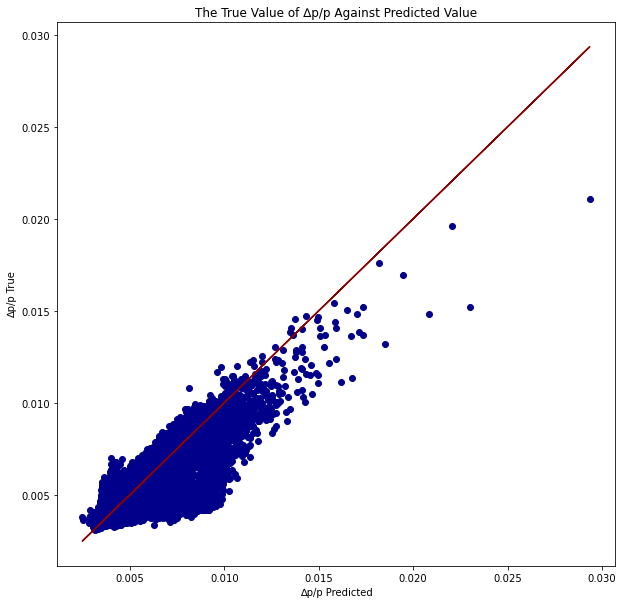

In [19]:
# Plotting scatter of predicted and true values
plt.scatter(model_target, predicted, color='darkblue')
plt.title('The True Value of ∆p/p Against Predicted Value')
plt.xlabel('∆p/p Predicted')
plt.ylabel('∆p/p True')
# Overlaying y = x line
plt.plot(model_target, model_target, color='darkred')
plt.show()

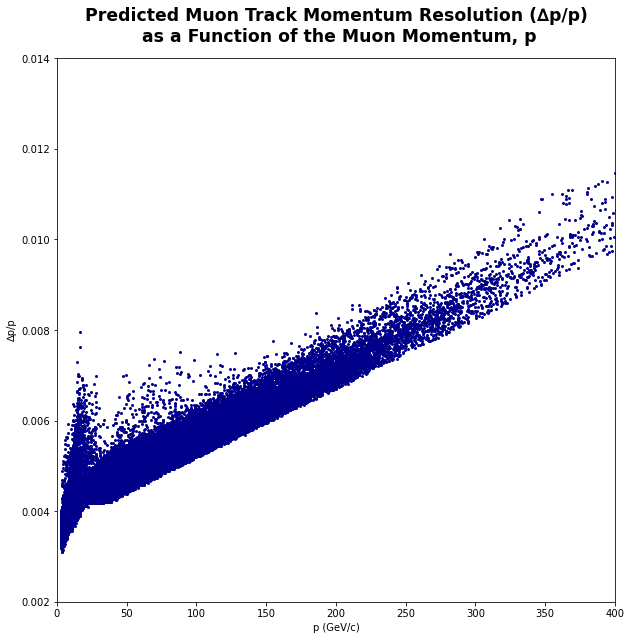

In [17]:
# Producing the momentum band scatter plot from predicted values
plt.scatter(data['p'], predicted, marker='.', linewidth=0.001, color='darkblue')
plt.xlim(0, 400)
plt.ylim(0.002, 0.014)
plt.title('Predicted Muon Track Momentum Resolution (∆p/p)\n as a Function of the Muon Momentum, p', y=1.02, weight='bold', size='xx-large')
plt.xlabel('p (GeV/c)')
plt.ylabel('∆p/p')
plt.show()